**Description**: Tries to answer [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/q/611877/337906). This
meta-analysis suggests that pretraining on test set features (no labels) can be okay.

**Estimated runtime**: ~25 minutes (Multi-core isn't working on my machine. Set
`cores=4` in the `model.fit` call if it works for you.)

Note: I'm still learning how to do this type of analysis. I need to investigate the MCMC
warnings.

In [1]:
import os

import arviz as az
import bambi as bmb
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Load data

In [3]:
_dfs = []
for accuracy_csv in sorted(os.listdir("accuracies")):
    _df = pd.read_csv(os.path.join("accuracies", accuracy_csv))
    _df["dataset"] = accuracy_csv.removesuffix(".csv")
    _dfs.append(_df)
accuracy_df = pd.concat(_dfs)
accuracy_df = accuracy_df[["dataset", "base", "extra", "test"]]

In [4]:
num_test = 200  # taken from bert/run.ipynb
num_correct_df = (accuracy_df.copy()[["base", "extra", "test"]] * num_test).astype(int, errors="raise")
num_correct_df["dataset"] = accuracy_df["dataset"].copy()
num_correct_df = num_correct_df[["dataset", "base", "extra", "test"]]
num_correct_df["pair"] = range(len(num_correct_df))
num_correct_df

,dataset,base,extra,test,pair
0,ag_news,142,173,175,0
1,ag_news,146,176,172,1
2,ag_news,147,164,167,2
3,ag_news,159,164,168,3
4,ag_news,153,169,165,4
...,...,...,...,...,...
25,yelp_review_full,57,65,63,415
26,yelp_review_full,62,76,70,416
27,yelp_review_full,54,63,45,417
28,yelp_review_full,52,73,65,418


# Model

A multilevel model is fit:

$$
\begin{align*}
Y_{ijk} \sim \text{Poisson}(\lambda_{ijk}) && \text{number of correct predictions} \\
\log(\lambda_{ijk}) = \mu + U_i + V_{ij} + \beta x_{ijk} && \text{additive effects} \\
U_i \sim \text{Normal}(\mu_{D}, \sigma_{D}) && \text{effect of dataset} \\
V_{ij} \sim \text{Normal}(\mu_{V}, \sigma_{V}) && \text{(nested) effect of dataset subsample (AKA pair)} \\
\mu, \mu_{D}, \mu_{V}, \beta \sim \text{Normal}(0, 1.5) && \text{prior for means} \\
\sigma_{D}, \sigma_{V} \sim \text{Exponential}(1) && \text{prior for standard deviations}.
\end{align*}
$$

$i = 1, 2, \dots, 14$ for the dataset.

$j = 1, 2, \dots, 30$ for the subsample of dataset $i$.

$k = 1, 2$ for control and treatment.

$x_{ijk} = 0$ if $k = 1$ else it's $1$. We'll perform inference on $\beta$ via MCMC.

# Analysis code

In [5]:
def violin_plot(
    accuracy_df: pd.DataFrame,
    paired_diff_column: str,
    title: str,
    color,
    **ylabel_kwargs
):
    _, axes = plt.subplots(figsize=(16, 2))
    axes: plt.Axes
    sns.violinplot(
        data=accuracy_df, x="dataset", y=paired_diff_column, ax=axes, color=color
    )
    axes.set_title(title)
    axes.yaxis.grid(True)
    axes.set_xlabel("Text classification dataset")
    axes.set_ylabel(**ylabel_kwargs)
    plt.xticks(rotation=45, ha="right")
    plt.show()

In [6]:
def eda(
    accuracy_df: pd.DataFrame,
    control_column: str,
    treatment_column: str,
    title: str,
    color,
    **ylabel_kwargs,
):
    accuracy_df = accuracy_df.copy()
    paired_diff_column = f"{treatment_column} - {control_column}"
    accuracy_df[paired_diff_column] = (
        accuracy_df[treatment_column] - accuracy_df[control_column]
    )
    violin_plot(accuracy_df, paired_diff_column, title, color, **ylabel_kwargs)
    # fmt: off
    summary = (
        accuracy_df
        .groupby("dataset")
        [paired_diff_column]
        .describe()
        [["mean", "std"]]
    )
    # fmt: on
    print(summary.mean())
    return summary.round(3)

In [7]:
def model(
    num_correct_df: pd.DataFrame, control_column: str, treatment_column: str
) -> tuple[bmb.Model, az.InferenceData]:
    df = (
        num_correct_df[["pair", "dataset", control_column, treatment_column]]
        .melt(["pair", "dataset"], var_name="method", value_name="num_correct")
        .sort_values("pair")
        .reset_index(drop=True)
    )
    # Pairs/subsamples were formed from the dataset. So it's nested, not crossed
    model = bmb.Model(
        "num_correct ~ method + (1|dataset/pair)", family="poisson", data=df
    )
    fit_summary: az.InferenceData = model.fit(
        cores=1, inference_method="mcmc", chains=4
    )
    az_summary: pd.DataFrame = az.summary(fit_summary)
    display(
        az_summary.loc[
            [index_name for index_name in az_summary.index if "method" in index_name]
        ]
    )

    az.plot_trace(fit_summary, compact=False, var_names="method", filter_vars="like")
    return model, fit_summary

# Does pretraining help?

This is our control.

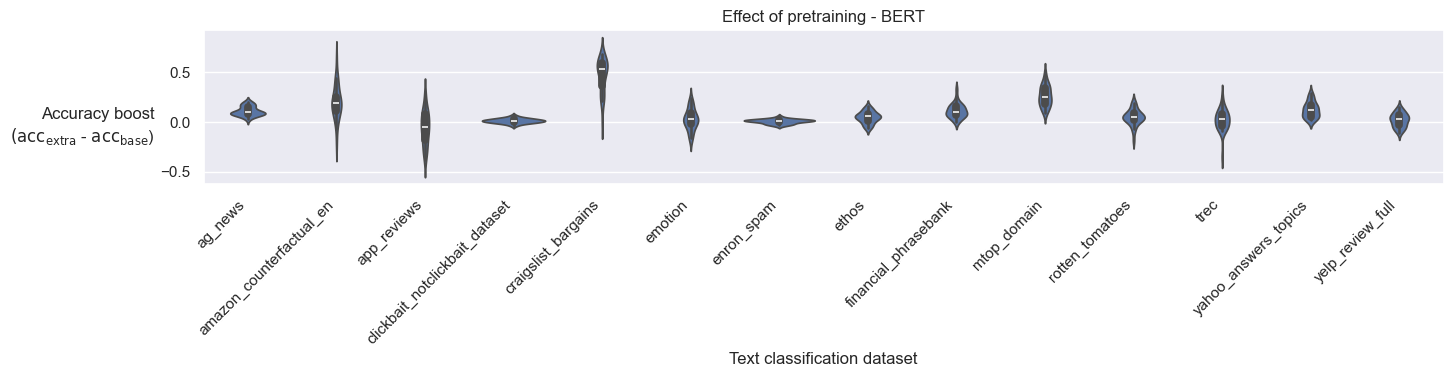

mean    0.099512
std     0.090765
dtype: float64


,mean,std
dataset,,
ag_news,0.109,0.047
amazon_counterfactual_en,0.200,0.171
app_reviews,-0.057,0.167
clickbait_notclickbait_dataset,0.012,0.023
craigslist_bargains,0.468,0.167
emotion,0.026,0.104
enron_spam,0.007,0.022
ethos,0.047,0.058
financial_phrasebank,0.112,0.071


In [8]:
eda(
    accuracy_df,
    control_column="base",
    treatment_column="extra",
    title="Effect of pretraining - BERT",
    color=None,
    ylabel=(
        "Accuracy boost\n$(\\text{acc}_\\text{extra}$ - $\\text{acc}_\\text{base}$)"
    ),
    rotation="horizontal",
    ha="right",
    va="top",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 632 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.177,0.007,0.165,0.19,0.0,0.0,5567.0,2701.0,1.0


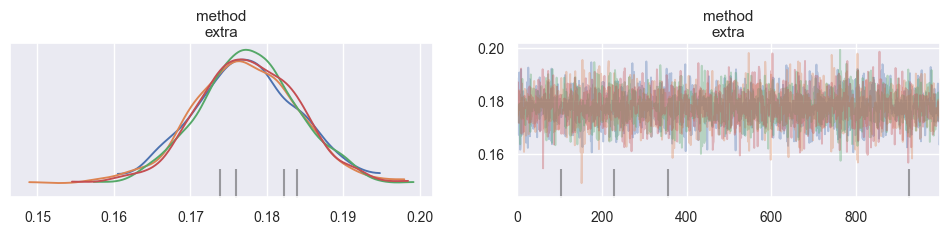

In [9]:
model_control, summary_control = model(
    num_correct_df, control_column="base", treatment_column="extra"
)

Good evidence that pretraining helps. There's an effect to detect.

# Does pretraining on test cause bias?

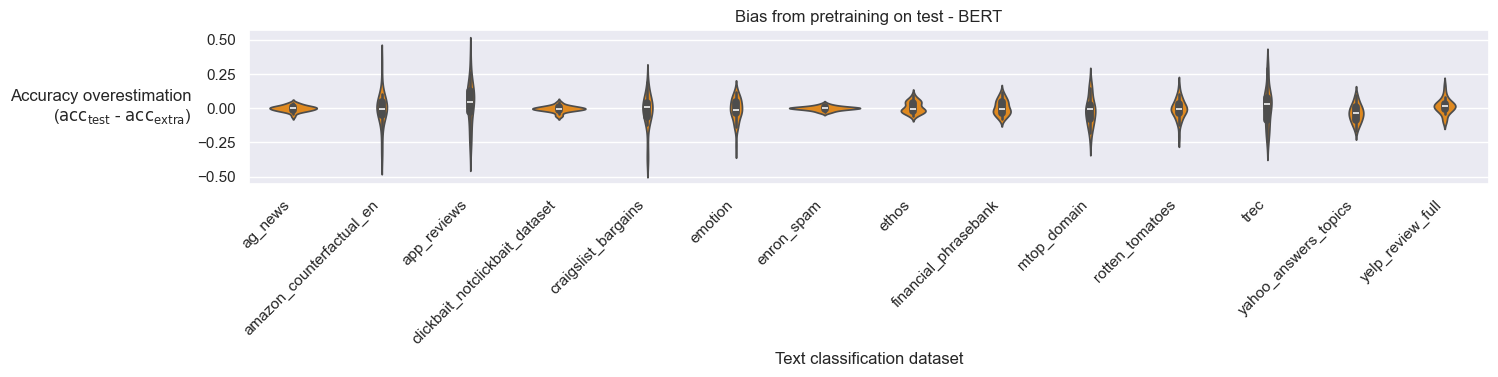

mean   -0.002571
std     0.076849
dtype: float64


,mean,std
dataset,,
ag_news,-0.001,0.022
amazon_counterfactual_en,-0.007,0.126
app_reviews,0.038,0.151
clickbait_notclickbait_dataset,-0.004,0.022
craigslist_bargains,-0.024,0.128
emotion,-0.013,0.086
enron_spam,-0.000,0.016
ethos,0.007,0.041
financial_phrasebank,0.005,0.053


In [10]:
eda(
    accuracy_df,
    control_column="extra",
    treatment_column="test",
    title="Bias from pretraining on test - BERT",
    color="darkorange",
    ylabel=(
        "Accuracy overestimation\n"
        "($\\text{acc}_\\text{test}$ - $\\text{acc}_\\text{extra}$)"
    ),
    rotation="horizontal",
    ha="right",
    va="center",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 618 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],-0.004,0.006,-0.016,0.008,0.0,0.0,6163.0,2725.0,1.0


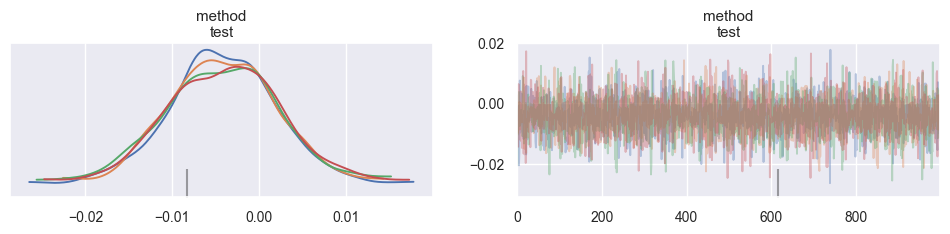

In [11]:
model_bias, summary_bias = model(
    num_correct_df, control_column="extra", treatment_column="test"
)

No evidence of bias. There's a tiny negative effect. But the data is too noisy to
support the seemingly preposterous statement that pretraining on test set texts hurts
test set performance compared to pretraining on independent texts.